**Table of contents**<a id='toc0_'></a>    
- 1. [Measuring synchronization of activity in Nankai ](#toc1_)    
- 2. [Load data](#toc2_)    
- 3. [Compute correlation distance](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Measuring synchronization of activity in Nankai  [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from stats import cross_corr

In [14]:
mag_min = 2.4

# 2. <a id='toc2_'></a>Load data [&#128285;](#toc0_)

In [15]:
# Tremor data
trm = pd.read_csv('data/nankai/processed/nank_trm_clust_0404_0413_trim_eqdist_mc{:.1f}.csv'.format(mag_min), parse_dates=['date'])

In [16]:
# Earthquake data
eq = pd.read_csv('data/nankai/processed/nank_eqmc{:.1f}_0404_0413_trim_eqdist.csv'.format(mag_min), parse_dates=['date'])

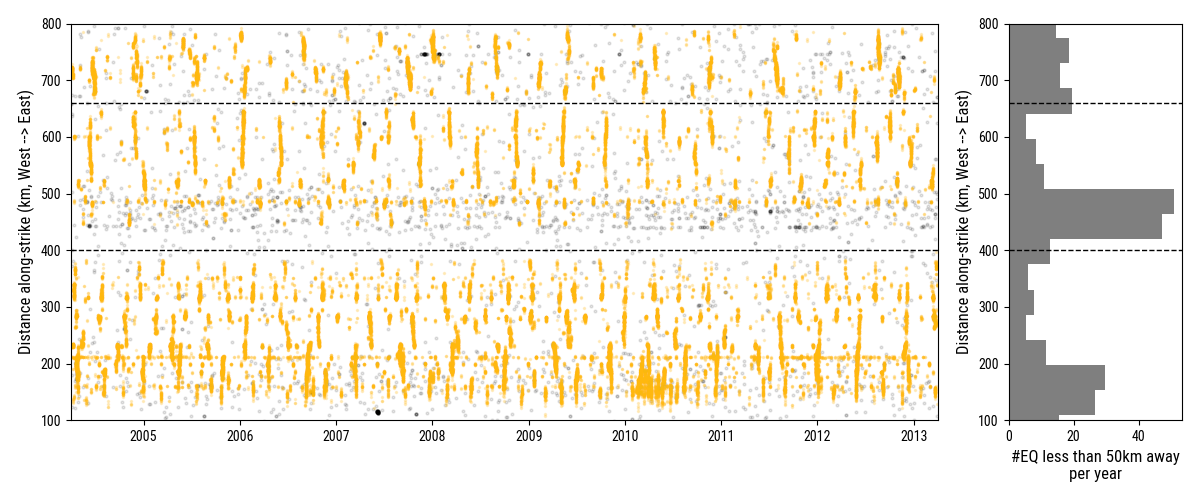

In [17]:
# Overview
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, .2])

# # Map
# # crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())
# crs = ccrs.PlateCarree()
# ax = fig.add_subplot(gs[0, 0], projection=crs)
# min_lat = 32.5
# max_lat = 35.7
# min_lon = 131
# max_lon = 138.5
# ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# ax.coastlines(lw=1)
# ax.add_feature(cfeature.LAND, color='lightgrey')

# ax.plot(trm.lon, trm.lat, 'o', ms=1, color='C2', transform=ccrs.PlateCarree())
# ax.plot(eq.lon, eq.lat, 'o', ms=1, color=to_rgba('k', .1), transform=ccrs.PlateCarree(), zorder=0)

# # grid and labels, only bottom and left, not top and right
# ax.set_xticks(np.arange(min_lon, max_lon+1, 2), crs=crs)
# ax.set_yticks(np.arange(np.ceil(min_lat), max_lat, 1), crs=crs)
# ax.xaxis.set_major_formatter(LongitudeFormatter())
# ax.yaxis.set_major_formatter(LatitudeFormatter())
# ax.grid('on', linestyle='--', alpha=0.5)

# Time-strike activity
ax = fig.add_subplot(gs[0, 0])
ax.set_ylabel('Distance along-strike (km, West --> East)')
ax.set_ylim(100, 800)
ax.set_xlim(trm.date.min(), trm.date.max())

ax.plot(trm.date, trm.xf, 'o', ms=1.5, color=to_rgba('C2', .2), label='Tremor')
ax.plot(eq.date[eq.in50km], eq.xf[eq.in50km], 'o', ms=2, color=to_rgba('k', .1), label='Earthquake', zorder=0)

# Histogram
ax = fig.add_subplot(gs[0, 1])
ax.set_xlabel('#EQ less than 50km away\nper year')
ax.set_ylabel('Distance along-strike (km, West --> East)')
ax.set_ylim(100, 800)

years = (eq.date.max() - eq.date.min()).days / 365
ax.hist(eq.xf[eq.in50km], weights=np.ones(len(eq.xf[eq.in50km]))/years, bins=20, color='k', alpha=.5, orientation='horizontal', histtype='stepfilled', lw=0)

for ax in fig.axes:
    ax.axhline(400, color='k', lw=1, ls='--')
    ax.axhline(660, color='k', lw=1, ls='--')

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Compute correlation distance [&#128285;](#toc0_)

In [18]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 100
xmax_bin = 800
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [19]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, trm.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    trm_in_bin = trm.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm[trm_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            if ~np.any(counts[ii, :]) or ~np.any(counts[jj, :]):
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.nan
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = np.nan
            else:
                cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
                
                if look_both_ways:
                    cc = (cc + cc[::-1]) / 2
                    cc = cc[lag >= 0]
                    lag = lag[lag >= 0]
                
                in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

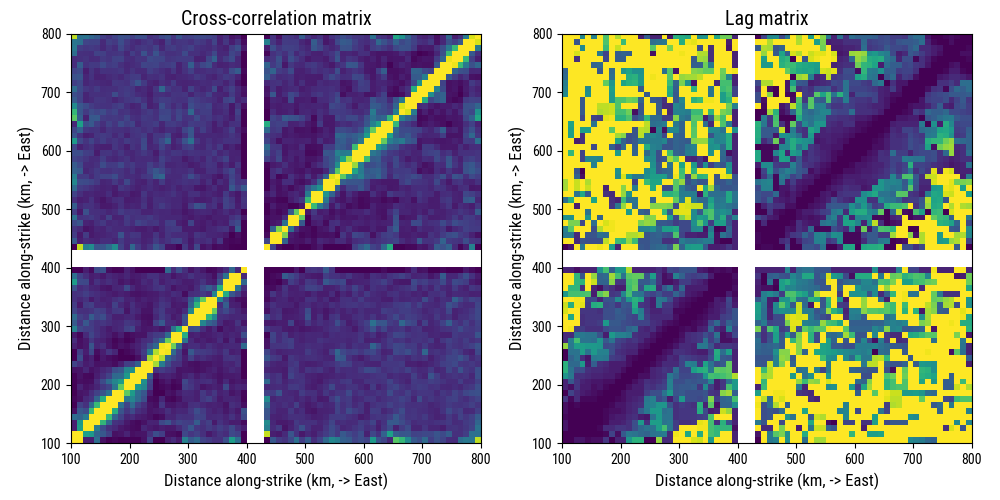

In [20]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]

# from matplotlib.colors import LinearSegmentedColormap
# nlow = int(256 * 0.1 // 1)
# nhigh = int(256 - nlow)
# cm_low = plt.cm.Greys_r(np.linspace(0, 1, nlow))
# cm_high = plt.cm.YlOrBr_r(np.linspace(0, 1, nhigh))
# colors = np.vstack((cm_low, cm_high))
# mymap = LinearSegmentedColormap.from_list('my_colormap', colors)

cax = ax.imshow(cc_matrix, extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], origin='lower', cmap='viridis', vmin=0, vmax=.4)
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=50, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

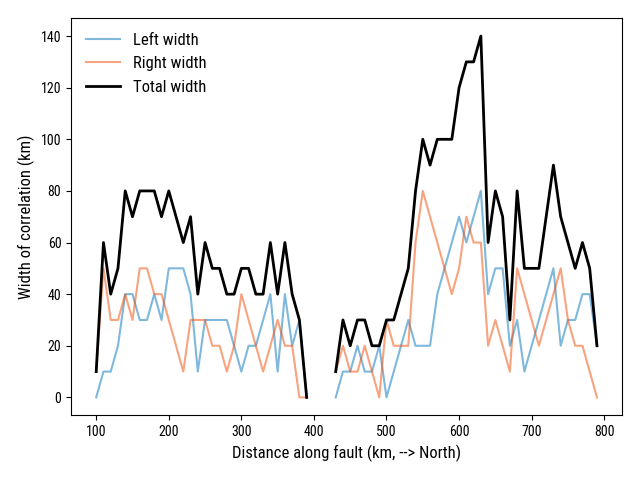

In [21]:
# Look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

left_width = np.array(left_width).astype(float)
right_width = np.array(right_width).astype(float)

# Remove wrong points
left_width[~np.any(counts, axis=1)] = np.nan
right_width[~np.any(counts, axis=1)] = np.nan

corr_length = np.array(left_width) + np.array(right_width)

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, '-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, '-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], corr_length, 'k-', label='Total width', lw=2)
ax.legend()
plt.tight_layout()
plt.show()

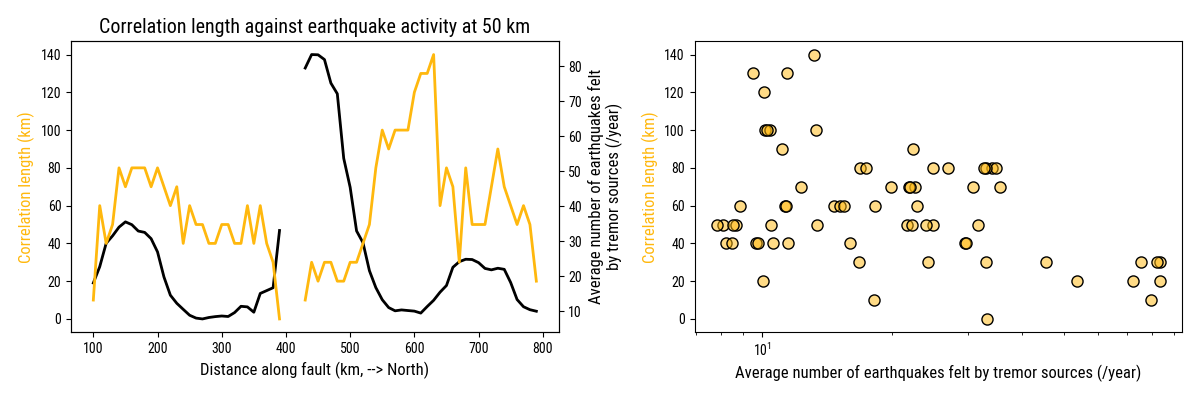

In [22]:
# Against earthquake activity
# --> Compute binned measure of earthquake activity
dists = [10, 20, 30, 50, 100]  # different distances in km

n_close_eq = {}
for dist in dists:
    n_close_eq[dist] = np.zeros(len(x_bin_edges)-1)
    for ii in range(len(x_bin_edges)-1):
        x_min = x_bin_edges[ii]
        x_max = x_bin_edges[ii+1]
        trm_in_bin = trm[trm.xf.between(x_min, x_max)]
        n_close_eq[dist][ii] = np.mean(trm_in_bin[f'n_eq_{dist}km'])

# Plot
chosen_dist = 50
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --> In space
ax = axes[0]
ax.set_title(f'Correlation length against earthquake activity at {chosen_dist} km')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2)

ax_eq = ax.twinx()
ax_eq.set_zorder(-10)
ax.set_facecolor('none')
ax_eq.set_ylabel('Average number of earthquakes felt\nby tremor sources (/year)', color='k')
ax_eq.plot(x_bin_edges[:-1], n_close_eq[chosen_dist], 'k-', lw=2)

# --> One against the other
ax = axes[1]
ax.set_xlabel('Average number of earthquakes felt by tremor sources (/year)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [23]:
# Stats
from scipy.stats import linregress

# Remove nans for the regression
n_eq = n_close_eq[chosen_dist][~np.isnan(corr_length)]
corr_l = corr_length[~np.isnan(corr_length)]

slope, intercept, r_value, p_value, std_err = linregress(n_eq, corr_l)
print('Slope:{:.2f}'.format(slope))
print('Error on slope (std): ±{:.2f}'.format(std_err))
print('Corellation coefficient:{:.2f}'.format(r_value))

SSres = np.sum((corr_l - (slope * n_eq + intercept))**2)  # sum of squares of residuals
SStot = np.sum((corr_l - np.mean(corr_l))**2)  # total sum of squares
R2 = 1 - SSres / SStot
print('Percentage of variance explained (R²): {:.1f}%'.format(100*R2))

Slope:-0.64
Error on slope (std): ±0.17
Corellation coefficient:-0.43
Percentage of variance explained (R²): 18.6%


In [24]:
# Save results
import pickle
results = {'corr_length': corr_length, 'n_close_eq': n_close_eq, 'dists':dists, 'cc_thr':threshold_cc, 'dx':dx_bin, 'dt': delta, 'min_mag': mag_min}

path = 'results/nank_synch_mc{:.1f}_dx{:d}_cc{:.2f}.pkl'.format(mag_min, int(dx_bin), threshold_cc)
with open(path, 'wb') as f:
    print(f'Saving at {path}')
    pickle.dump(results, f)

Saving at results/nank_synch_mc2.4_dx10_cc0.07.pkl
